##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TFRecords と `tf.Example` の使用法

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/load_data/tf-records"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/tf-records.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/load_data/tf-records.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

データの読み込みを効率的にするには、データをシリアライズし、連続的に読み込めるファイルのセット（各ファイルは100-200MB）に保存することが有効です。データをネットワーク経由で流そうとする場合には、特にそうです。また、データの前処理をキャッシングする際にも役立ちます。

TFRecord形式は、バイナリレコードの系列を保存するための単純な形式です。

[プロトコルバッファ](https://developers.google.com/protocol-buffers/) は、構造化データを効率的にシリアライズする、プラットフォームや言語に依存しないライブラリです。

プロトコルメッセージは`.proto`という拡張子のファイルで表されます。メッセージの型を識別する最も簡単な方法です。

`tf.Example`メッセージ（あるいはプロトコルバッファ）は、`{"string": value}`形式のマッピングを表現する柔軟なメッセージタイプです。これは、TensorFlow用に設計され、[TFX](https://www.tensorflow.org/tfx/)のような上位レベルのAPIで共通に使用されています。

このノートブックでは、`tf.Example`の作成、解析と使用法をデモし、その後、`tf.Example`メッセージを`.tfrecord`に書き出し、読み取る方法を示します。

注：こうした構造は有用ですが必ずそうしなければならなというものではありません。[`tf.data`](https://www.tensorflow.org/guide/datasets) を使っていて、データの読み込みが訓練のボトルネックである場合でなければ、既存のコードをTFRecordsを使用するために変更する必要はありません。データセットの性能改善のヒントは、 [Data Input Pipeline Performance](https://www.tensorflow.org/guide/performance/datasets)を参照ください。

## 設定

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
tf.enable_eager_execution()

import numpy as np
import IPython.display as display

## `tf.Example`

###  `tf.Example`用のデータ型

基本的には`tf.Example`は`{"string": tf.train.Feature}`というマッピングです。

`tf.train.Feature`メッセージ型は次の3つの型のうち1つをとることができます。（[.proto file](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/core/example/feature.proto)を参照）この他の一般的なデータ型のほとんどは、強制的にこれらのうちの1つにすること可能です。

1. `tf.train.BytesList` (次の型のデータを扱うことが可能)
  - `string`
  - `byte`  
1. `tf.train.FloatList` (次の型のデータを扱うことが可能)
  - `float` (`float32`)
  - `double` (`float64`)  
1. `tf.train.Int64List` (次の型のデータを扱うことが可能)
  - `bool`
  - `enum`
  - `int32`
  - `uint32`
  - `int64`
  - `uint64`

通常のTensorFlowの型を`tf.Example`互換の `tf.train.Feature`に変換するには、次のショートカット関数を使うことができます。

どの関数も、1個のスカラー値を入力とし、上記の3つの`list`型のうちの一つを含む`tf.train.Feature`を返します。

In [3]:
# 下記の関数を使うと値を tf.Exampleと互換性の有る型に変換できる

def _bytes_feature(value):
    """string / byte 型から byte_listを返す"""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """float / double 型から float_listを返す"""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """bool / enum / int / uint 型から Int64_listを返す"""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

注：単純化のため、このサンプルではスカラー値の入力のみを扱っています。スカラー値ではない特徴を扱う最も簡単な方法は、`tf.serialize_tensor`を使ってテンソルをバイナリ文字列に変換する方法です。TensorFlowでは文字列はスカラー値として扱います。バイナリ文字列をテンソルに戻すには、`tf.parse_tensor`を使用します。

上記の関数の使用例を下記に示します。入力が様々な型であるのに対して、出力が標準化されていることに注目してください。入力が、強制変換できない型であった場合、例外が発生します。（例：`_int64_feature(1.0)`はエラーとなります。`1.0`が浮動小数点数であるためで、代わりに`_float_feature`関数を使用すべきです）

In [4]:
print(_bytes_feature(b'test_string'))
print(_bytes_feature(u'test_bytes'.encode('utf-8')))

print(_float_feature(np.exp(1)))

print(_int64_feature(True))
print(_int64_feature(1))

bytes_list {
  value: "test_string"
}

bytes_list {
  value: "test_bytes"
}

float_list {
  value: 2.7182817459106445
}

int64_list {
  value: 1
}

int64_list {
  value: 1
}



主要なメッセージはすべて`.SerializeToString` を使ってバイナリ文字列にシリアライズすることができます。

In [5]:
feature = _float_feature(np.exp(1))

feature.SerializeToString()

b'\x12\x06\n\x04T\xf8-@'

### `tf.Example` メッセージの作成

既存のデータから`tf.Example`を作成したいとします。実際には、データセットの出処はどこでも良いのですが、1件の観測記録から`tf.Example`メッセージを作る手順は同じです。

1. 観測記録それぞれにおいて、各値は上記の関数を使って3種類の互換性のある型をからなる`tf.train.Feature`に変換する必要があります。

1. 次に、特徴の名前を表す文字列と、#1で作ったエンコード済みの特徴量を対応させたマップ（ディクショナリ）を作成します。

1. #2で作成したマップを[特徴量メッセージ](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/core/example/feature.proto#L85)に変換します。

このノートブックでは、NumPyを使ってデータセットを作成します。

このデータセットには4つの特徴量があります。
- `False` または `True`を表す論理値。出現確率は等しいものとします。
- ランダムなバイト値。全体において一様であるとします。
- `[-10000, 10000)`の範囲から一様にサンプリングした整数値。
- 標準正規分布からサンプリングした浮動小数点数。

サンプルは上記の分布から独立して同じ様に分布した10,000件の観測記録からなるものとします。

In [6]:
# データセットに含まれる観測結果の件数
n_observations = int(1e4)

# ブール特徴量 FalseまたはTrueとしてエンコードされている
feature0 = np.random.choice([False, True], n_observations)

# 整数特徴量  -10000 から 10000 の間の乱数
feature1 = np.random.randint(0, 5, n_observations)

# バイト特徴量
strings = np.array([b'cat', b'dog', b'chicken', b'horse', b'goat'])
feature2 = strings[feature1]

# 浮動小数点数特徴量 標準正規分布から発生
feature3 = np.random.randn(n_observations)

これらの特徴量は、`_bytes_feature`, `_float_feature`, `_int64_feature`のいずれかを使って`tf.Example`互換の型に強制変換されます。その後、エンコード済みの特徴量から`tf.Example`メッセージを作成できます。

In [7]:
def serialize_example(feature0, feature1, feature2, feature3):
    """
    Creates a tf.Example message ready to be written to a file.
    ファイル出力可能なtf.Exampleメッセージを作成する
    """

    # 特徴量名とtf.Example互換データ型との対応ディクショナリを作成

    feature = {
        'feature0': _int64_feature(feature0),
        'feature1': _int64_feature(feature1),
        'feature2': _bytes_feature(feature2),
        'feature3': _float_feature(feature3),
    }

    # tf.train.Exampleを用いて特徴メッセージを作成

    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

例えば、データセットに`[False, 4, bytes('goat'), 0.9876]`という1つの観測記録があるとします。`create_message()`を使うとこの観測記録から`tf.Example`メッセージを作成し印字できます。上記のように、観測記録一つ一つが`Features`メッセージとして書かれています。`tf.Example` [メッセージ](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/core/example/example.proto#L88)は、この`Features` メッセージを包むラッパーに過ぎないことに注意してください。

In [8]:
# データセットからの観測記録の例

example_observation = []

serialized_example = serialize_example(False, 4, b'goat', 0.9876)
serialized_example

b'\nR\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04[\xd3|?\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x04\n\x14\n\x08feature2\x12\x08\n\x06\n\x04goat'

メッセージをデコードするには、`tf.train.Example.FromString`メソッドを使用します。

In [9]:
example_proto = tf.train.Example.FromString(serialized_example)
example_proto

features {
  feature {
    key: "feature0"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "feature1"
    value {
      int64_list {
        value: 4
      }
    }
  }
  feature {
    key: "feature2"
    value {
      bytes_list {
        value: "goat"
      }
    }
  }
  feature {
    key: "feature3"
    value {
      float_list {
        value: 0.9876000285148621
      }
    }
  }
}

## `tf.data`を使用したTFRecordファイル

`tf.data`モジュールには、TensorFlowでデータを読み書きするツールが含まれます。

### TFRecordファイルの書き出し

データをデータセットにする最も簡単な方法は`from_tensor_slices`メソッドです。

配列に適用すると、このメソッドはスカラー値のデータセットを返します。

In [10]:
tf.data.Dataset.from_tensor_slices(feature1)

<DatasetV1Adapter shapes: (), types: tf.int64>

配列のタプルに適用すると、タプルのデータセットが返されます。

In [11]:
features_dataset = tf.data.Dataset.from_tensor_slices((feature0, feature1, feature2, feature3))
features_dataset

<DatasetV1Adapter shapes: ((), (), (), ()), types: (tf.bool, tf.int64, tf.string, tf.float64)>

In [12]:
#  データセットから1つのサンプルだけを取り出すには`take(1)` を使います。
for f0,f1,f2,f3 in features_dataset.take(1):
    print(f0)
    print(f1)
    print(f2)
    print(f3)

Instructions for updating:
Colocations handled automatically by placer.
tf.Tensor(False, shape=(), dtype=bool)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(b'goat', shape=(), dtype=string)
tf.Tensor(-0.2768728503385437, shape=(), dtype=float64)


`Dataset`のそれぞれの要素に関数を適用するには、`tf.data.Dataset.map`メソッドを使用します。

マップされる関数はTensorFlowのグラフモードで動作する必要があります。関数は`tf.Tensors`を処理し、返す必要があります。`create_example`のような非テンソル関数は、互換性のため`tf.py_func`でラップすることができます。

`tf.py_func`を使用する際には、シェイプと型は取得できないため、指定する必要があります。

In [13]:
def tf_serialize_example(f0,f1,f2,f3):
    tf_string = tf.py_func(
        serialize_example, 
        (f0,f1,f2,f3),  # pass these args to the above function.
        tf.string)      # the return type is `tf.string`.
    return tf.reshape(tf_string, ()) # The result is a scalar

この関数をデータセットのそれぞれの要素に適用します。

In [14]:
serialized_features_dataset = features_dataset.map(tf_serialize_example)
serialized_features_dataset

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    


<DatasetV1Adapter shapes: (), types: tf.string>

TFRecordファイルに書き出します。

In [15]:
filename = 'test.tfrecord'
writer = tf.data.experimental.TFRecordWriter(filename)
writer.write(serialized_features_dataset)

### TFRecordファイルの読み込み

`tf.data.TFRecordDataset`クラスを使ってTFRecordファイルを読み込むこともできます。

`tf.data`を使ってTFRecordファイルを取り扱う際の詳細については、[こちら](https://www.tensorflow.org/guide/datasets#consuming_tfrecord_data)を参照ください。 

`TFRecordDataset`を使うことは、入力データを標準化し、パフォーマンスを最適化するのに有用です。

In [16]:
filenames = [filename]
raw_dataset = tf.data.TFRecordDataset(filenames)
raw_dataset

<TFRecordDatasetV1 shapes: (), types: tf.string>

この時点で、データセットにはシリアライズされた`tf.train.Example`メッセージが含まれています。データセットをイテレートすると、スカラーの文字列テンソルが返ってきます。

`.take`メソッドを使って最初の10レコードだけを表示します。

注：`tf.data.Dataset`をイテレートできるのは、Eager Executionが有効になっている場合のみです。

In [17]:
for raw_record in raw_dataset.take(10):
    print(repr(raw_record))

<tf.Tensor: id=51, shape=(), dtype=string, numpy=b'\nR\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x04\n\x14\n\x08feature2\x12\x08\n\x06\n\x04goat\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04G\xc2\x8d\xbe'>
<tf.Tensor: id=53, shape=(), dtype=string, numpy=b'\nS\n\x15\n\x08feature2\x12\t\n\x07\n\x05horse\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04c\xad\xd3>\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x03'>
<tf.Tensor: id=55, shape=(), dtype=string, numpy=b'\nQ\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04\xe3pI?\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x01\n\x13\n\x08feature2\x12\x07\n\x05\n\x03dog'>
<tf.Tensor: id=57, shape=(), dtype=string, numpy=b'\nS\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x03\n\x15\n\x08feature2\x12\t\n\x07\n\x05horse\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04\xd6\xdd\xbc?'>
<tf.Tensor: id=59, s

これらのテンソルは下記の関数でパースできます。

注：ここでは、`feature_description`が必要です。データセットはグラフ実行を使用するため、この記述を使ってシェイプと型を構築するのです。

In [18]:
# 特徴の記述
feature_description = {
    'feature0': tf.FixedLenFeature([], tf.int64, default_value=0),
    'feature1': tf.FixedLenFeature([], tf.int64, default_value=0),
    'feature2': tf.FixedLenFeature([], tf.string, default_value=''),
    'feature3': tf.FixedLenFeature([], tf.float32, default_value=0.0),
}

def _parse_function(example_proto):
  # 上記の記述を使って入力のtf.Exampleを処理
  return tf.parse_single_example(example_proto, feature_description)

あるいは、`tf.parse example`を使ってバッチ全体を一度にパースします。

`tf.data.Dataset.map`メソッドを使って、データセットの各アイテムにこの関数を適用します。

In [19]:
parsed_dataset = raw_dataset.map(_parse_function)
parsed_dataset 

<DatasetV1Adapter shapes: {feature0: (), feature1: (), feature2: (), feature3: ()}, types: {feature0: tf.int64, feature1: tf.int64, feature2: tf.string, feature3: tf.float32}>

Eager Execution を使ってデータセット中の観測記録を表示します。このデータセットには10,000件の観測記録がありますが、最初の10個だけ表示します。  
データは特徴量のディクショナリの形で表示されます。それぞれの項目は`tf.Tensor`であり、このテンソルの`numpy` 要素は特徴量を表します。

In [20]:
for parsed_record in parsed_dataset.take(10):
  print(repr(raw_record))

<tf.Tensor: id=69, shape=(), dtype=string, numpy=b'\nQ\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x01\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x01\n\x13\n\x08feature2\x12\x07\n\x05\n\x03dog\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04^\xc5\x8b\xbe'>
<tf.Tensor: id=69, shape=(), dtype=string, numpy=b'\nQ\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x01\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x01\n\x13\n\x08feature2\x12\x07\n\x05\n\x03dog\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04^\xc5\x8b\xbe'>
<tf.Tensor: id=69, shape=(), dtype=string, numpy=b'\nQ\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x01\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x01\n\x13\n\x08feature2\x12\x07\n\x05\n\x03dog\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04^\xc5\x8b\xbe'>
<tf.Tensor: id=69, shape=(), dtype=string, numpy=b'\nQ\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x01\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x01\n\x13\n\x08feature2\x12\x07\n\x05\n\x03dog\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04^\xc5\x8b\xbe'>
<tf.Tensor: 

ここでは、`tf.parse_example` が`tf.Example`のフィールドを通常のテンソルに展開しています。

## tf.python_ioを使ったTFRecordファイル

`tf.python_io`モジュールには、TFRecordファイルの読み書きのための純粋なPython関数も含まれています。

### TFRecordファイルの書き出し

次にこの10,000件の観測記録を`test.tfrecords`ファイルに出力します。観測記録はそれぞれ`tf.Example`メッセージに変換され、ファイルに出力されます。その後、`test.tfrecords`ファイルが作成されたことを確認することができます。

In [21]:
# `tf.Example`観測記録をファイルに出力
with tf.python_io.TFRecordWriter(filename) as writer:
  for i in range(n_observations):
    example = serialize_example(feature0[i], feature1[i], feature2[i], feature3[i])
    writer.write(example)

In [22]:
!ls

images.ipynb     images.tfrecords test.tfrecord    tf-records.ipynb


### TFRecordファイルの読み込み

モデルに入力にするため、このデータを読み込みたいとしましょう。

次の例では、データをそのまま、`tf.Example`メッセージとしてインポートします。これは、ファイルが期待されるデータを含んでいるかを確認するのに役に立ちます。これは、また、入力データがTFRecordとして保存されているが、[この](https://www.tensorflow.org/guide/datasets#consuming_numpy_arrays)例のようにNumPyデータ（またはそれ以外のデータ型）として入力したい場合に有用です。このコーディング例では値そのものを読み取れるからです。

入力ファイルの中のTFRecordをイテレートして、`tf.Example`メッセージを取り出し、その中の値を読み取って保存できます。

In [23]:
record_iterator = tf.python_io.tf_record_iterator(path=filename)

for string_record in record_iterator:
  example = tf.train.Example()
  example.ParseFromString(string_record)
  
  print(example)
  
  # Exit after 1 iteration as this is purely demonstrative.
  # 純粋にデモであるため、イテレーションの1回目で終了
  break

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
features {
  feature {
    key: "feature0"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "feature1"
    value {
      int64_list {
        value: 4
      }
    }
  }
  feature {
    key: "feature2"
    value {
      bytes_list {
        value: "goat"
      }
    }
  }
  feature {
    key: "feature3"
    value {
      float_list {
        value: -0.276872843503952
      }
    }
  }
}



（上記で作成した`tf.Example`型の）`example`オブジェクトの特徴量は（他のプロトコルバッファメッセージと同様に）ゲッターを使ってアクセス可能です。`example.features`は`repeated feature`メッセージを返し、`feature`メッセージをを取得すると（Pythonのディクショナリとして保存された）特徴量の名前と特徴量の値のマッピングが得られます。

In [24]:
print(dict(example.features.feature))

{'feature0': int64_list {
  value: 0
}
, 'feature1': int64_list {
  value: 4
}
, 'feature2': bytes_list {
  value: "goat"
}
, 'feature3': float_list {
  value: -0.276872843503952
}
}


このディクショナリから、指定した値をディクショナリとして得ることができます。

In [25]:
print(example.features.feature['feature3'])

float_list {
  value: -0.276872843503952
}



次に、ゲッターを使って値にアクセスできます。

In [26]:
print(example.features.feature['feature3'].float_list.value)

[-0.276872843503952]


## ウォークスルー： 画像データの読み書き

以下は、TFRecordを使って画像データを読み書きする方法の例です。この例の目的は、データ（この場合は画像）を入力し、そのデータをTFRecordファイルに書き込んで、再びそのファイルを読み込み、画像を表示するという手順を最初から最後まで示すことです。

これは、例えば、同じ入力データセットを使って複数のモデルを構築するといった場合に役立ちます。画像データをそのまま保存する代わりに、TFRecord形式に前処理しておき、その後の処理やモデル構築に使用することができます。

まずは、雪の中の猫の[画像](https://commons.wikimedia.org/wiki/File:Felis_catus-cat_on_snow.jpg)と、ニューヨーク市にあるウイリアムズバーグ橋の [写真](https://upload.wikimedia.org/wikipedia/commons/f/fe/New_East_River_Bridge_from_Brooklyn_det.4a09796u.jpg)をダウンロードしましょう。

### 画像の取得

In [27]:
cat_in_snow  = tf.keras.utils.get_file('320px-Felis_catus-cat_on_snow.jpg', 'https://upload.wikimedia.org/wikipedia/commons/thumb/b/b6/Felis_catus-cat_on_snow.jpg/320px-Felis_catus-cat_on_snow.jpg')
williamsburg_bridge = tf.keras.utils.get_file('194px-New_East_River_Bridge_from_Brooklyn_det.4a09796u.jpg','https://upload.wikimedia.org/wikipedia/commons/thumb/f/fe/New_East_River_Bridge_from_Brooklyn_det.4a09796u.jpg/194px-New_East_River_Bridge_from_Brooklyn_det.4a09796u.jpg')

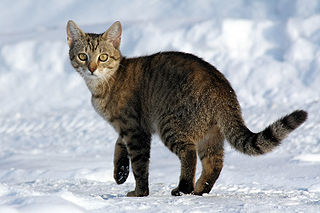

In [28]:
display.display(display.Image(filename=cat_in_snow))
display.display(display.HTML('Image cc-by: <a "href=https://commons.wikimedia.org/wiki/File:Felis_catus-cat_on_snow.jpg">Von.grzanka</a>'))

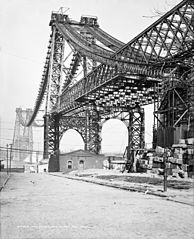

In [29]:
display.display(display.Image(filename=williamsburg_bridge))
display.display(display.HTML('<a "href=https://commons.wikimedia.org/wiki/File:New_East_River_Bridge_from_Brooklyn_det.4a09796u.jpg">source</a>'))

### TFRecordファイルの書き出し

上記で行ったように、この特徴量を`tf.Example`と互換のデータ型にエンコードできます。この場合には、生の画像文字列を特徴として保存するだけではなく、縦、横のサイズにチャネル数、更に画像を保存する際に猫の画像と橋の画像を区別するための`label`特徴量を付け加えます。猫の画像には`0`を、橋の画像には`1`を使うことにしましょう。

In [30]:
image_labels = {
    cat_in_snow : 0,
    williamsburg_bridge : 1,
}

In [31]:
# 猫の画像を使った例
image_string = open(cat_in_snow, 'rb').read()

label = image_labels[cat_in_snow]

# 関連する特徴量のディクショナリを作成
def image_example(image_string, label):
  image_shape = tf.image.decode_jpeg(image_string).shape

  feature = {
      'height': _int64_feature(image_shape[0]),
      'width': _int64_feature(image_shape[1]),
      'depth': _int64_feature(image_shape[2]),
      'label': _int64_feature(label),
      'image_raw': _bytes_feature(image_string),
  }

  return tf.train.Example(features=tf.train.Features(feature=feature))

for line in str(image_example(image_string, label)).split('\n')[:15]:
  print(line)
print('...')

features {
  feature {
    key: "depth"
    value {
      int64_list {
        value: 3
      }
    }
  }
  feature {
    key: "height"
    value {
      int64_list {
        value: 213
      }
...


ご覧のように、すべての特徴量が`tf.Example`メッセージに保存されました。上記のコードを関数化し、このサンプルメッセージを`images.tfrecords`ファイルに書き込みます。

In [32]:
# 生の画像をimages.tfrecordsファイルに書き出す
# まず、2つの画像をtf.Exampleメッセージに変換し、
# 次に.tfrecordsファイルに書き出す
with tf.python_io.TFRecordWriter('images.tfrecords') as writer:
  for filename, label in image_labels.items():
    image_string = open(filename, 'rb').read()
    tf_example = image_example(image_string, label)
    writer.write(tf_example.SerializeToString())

In [33]:
!ls

images.ipynb     images.tfrecords test.tfrecord    tf-records.ipynb


### TFRecordファイルの読み込み

これで、`images.tfrecords`ファイルができました。このファイルの中のレコードをイテレートし、書き込んだものを読み出します。このユースケースでは、画像を復元するだけなので、必要なのは生画像の文字列だけです。上記のゲッター、すなわち、`example.features.feature['image_raw'].bytes_list.value[0]`を使って抽出することができます。猫と橋のどちらであるかを決めるため、ラベルも使用します。

In [34]:
raw_image_dataset = tf.data.TFRecordDataset('images.tfrecords')

# 特徴量を記述するディクショナリを作成
image_feature_description = {
    'height': tf.FixedLenFeature([], tf.int64),
    'width': tf.FixedLenFeature([], tf.int64),
    'depth': tf.FixedLenFeature([], tf.int64),
    'label': tf.FixedLenFeature([], tf.int64),
    'image_raw': tf.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
  # 入力のtf.Exampleのプロトコルバッファを上記のディクショナリを使って解釈
  return tf.parse_single_example(example_proto, image_feature_description)

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
parsed_image_dataset

<DatasetV1Adapter shapes: {depth: (), height: (), image_raw: (), label: (), width: ()}, types: {depth: tf.int64, height: tf.int64, image_raw: tf.string, label: tf.int64, width: tf.int64}>

TFRecordファイルから画像を復元しましょう。

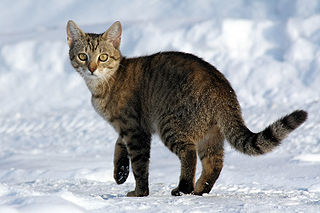

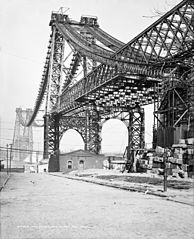

In [35]:
for image_features in parsed_image_dataset:
  image_raw = image_features['image_raw'].numpy()
  display.display(display.Image(data=image_raw))